<a href="https://colab.research.google.com/github/mwangi21/DATA-SCIENCE-JOB-SALARY-ANALYSIS/blob/main/Customer_Segmentation_%26_Cohort_Analysis_%26_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade kagglehub


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
#
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os



In [3]:
#Load the Data
df=pd.read_excel('/content/Online Retail.xlsx')


# **Data Preprocessing**

In [4]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
display(df.describe())

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [6]:
#Drop Duplicates
df.drop_duplicates(inplace=True)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0) & (df['CustomerID'].notnull())]



In [7]:
df.shape

(392692, 8)

# Cohort Analysis


In [8]:
def get_month(x): return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

In [9]:
def get_date_int(df, column):
  year = df[column].dt.year
  month = df[column].dt.month
  day = df[column].dt.day
  return year,month,day

In [10]:
invoice_year, invoice_month, invoice_day = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, cohort_day = get_date_int(df, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

df['CohortIndex'] = years_diff * 12 + months_diff + 1

df.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01,5
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01,5
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01,5
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01,5
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01,5


In [11]:
#Grouping
grouping = df.groupby(['CohortMonth', 'CohortIndex'])

cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

cohort_data = cohort_data.reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns='CohortIndex',
                                 values='CustomerID')


In [12]:
#Cohort Size
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index=retention.index.date

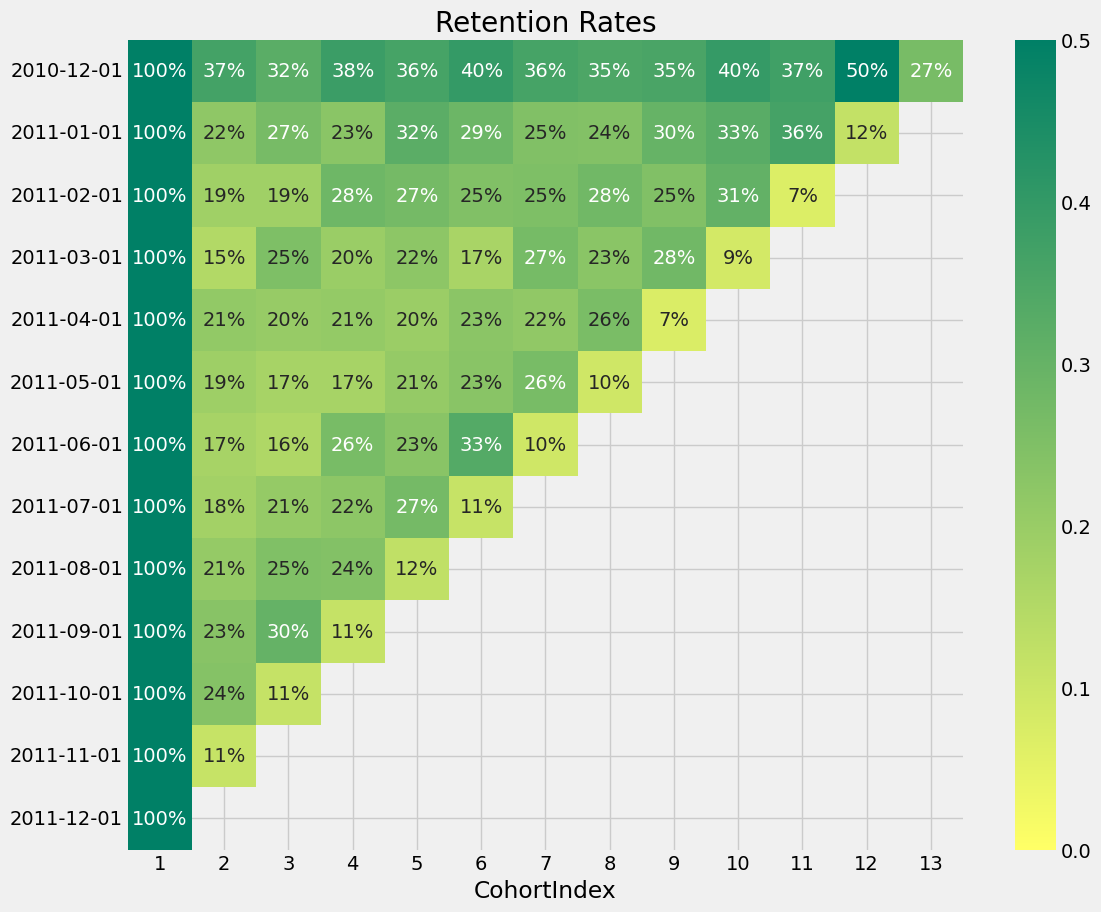

In [13]:
#sns.set()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,10))
plt.title('Retention Rates')
sns.heatmap(data = retention,
           annot = True,
           fmt = '.0%',
           vmin= 0.0,
           vmax=0.5,
           cmap='summer_r')
plt.show()

# **Customer segmentation with RFM**

In [14]:
#Recency,Frequency,Monetary value

In [15]:
df['InvoiceDay'] = df['InvoiceDate'].apply (lambda x: dt.datetime( x.year, x.month, x.day))
act_date = max (df['InvoiceDay'] + dt.timedelta(1))
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df.drop(['CohortMonth', 'InvoiceMonth', 'CohortIndex'], axis=1, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [16]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (act_date - x.max()).days,
    'InvoiceNo' : 'count',
    'TotalSum' : 'sum'
})

rfm.rename(columns = {'InvoiceDate' : 'Recency',
                      'InvoiceNo' : 'Frequency',
                      'TotalSum' : 'MonetaryValue'}, inplace = True)
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


In [17]:
r_labels = range(3, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 3, labels = r_labels)

f_labels = range(1, 4)
f_groups = pd.qcut(rfm.Frequency, q = 3, labels = f_labels)

m_labels = range(1, 4)
m_groups = pd.qcut(rfm.MonetaryValue, q = 3, labels = m_labels)

In [18]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

rfm = rfm.assign(R=r_groups,F=f_groups,M=m_groups)

rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.tail()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
18280.0,277,10,180.60,1,1,1,1.01.01.0,3
18281.0,180,7,80.82,1,1,1,1.01.01.0,3
18282.0,7,12,178.05,3,1,1,3.01.01.0,5
18283.0,3,721,2045.53,3,3,3,3.03.03.0,9
18287.0,42,70,1837.28,2,2,3,2.02.03.0,7


In [19]:
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'MonetaryValue' : ['mean', 'count']
})

rfm_agg.rename(columns = {'mean' : 'Mean','count' : 'Count'},
               inplace = True)

rfm_agg.round(1).head()

Recency Frequency MonetaryValue      
             Mean      Mean          Mean Count
RFM_Score                                      
3           237.4      10.6         200.6   636
4           137.2      19.1         313.3   561
5           110.2      28.9         775.2   704
6            66.2      47.2         829.2   621
7            48.3      73.6        1625.3   558

In [20]:
#Bronze-Occasionally Spenders,Silver- Regular Shopper,Gold -Elite Shopper

In [21]:
score_labels = ['Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q = 3, labels = score_labels)
rfm['Robust RFM Level'] = score_groups.values

rfm.head(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,Robust RFM Level
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,1,1,3,1.01.03.0,5,Bronze
12347.0,2,182,4310.00,3,3,3,3.03.03.0,9,Gold
12348.0,75,31,1797.24,2,2,3,2.02.03.0,7,Silver
12349.0,18,73,1757.55,3,3,3,3.03.03.0,9,Gold
12350.0,310,17,334.40,1,1,1,1.01.01.0,3,Bronze
12352.0,36,85,2506.04,2,3,3,2.03.03.0,8,Gold
12353.0,204,4,89.00,1,1,1,1.01.01.0,3,Bronze
12354.0,232,58,1079.40,1,2,2,1.02.02.0,5,Bronze
12355.0,214,13,459.40,1,1,2,1.01.02.0,4,Bronze


In [22]:
rfm.describe()

,Recency,Frequency,MonetaryValue,RFM_Score
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.059474,90.523744,2048.688081,6.007838
std,100.012264,225.506968,8985.230220,2.021999
min,0.000000,1.000000,3.750000,3.000000
25%,17.000000,17.000000,306.482500,4.000000
50%,50.000000,41.000000,668.570000,6.000000
75%,141.750000,98.000000,1660.597500,8.000000
max,373.000000,7676.000000,280206.020000,9.000000


Data Scaling


In [31]:
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]

rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1)

In [32]:
#Create a StandardScaler Instance
scaler = StandardScaler()
scaler.fit(rfm_log)
rfm_normalized= scaler.transform(rfm_log)

In [33]:
rfm_scaled = pd.DataFrame(rfm_normalized, index = rfm.index, columns = rfm_log.columns)
rfm.describe()

,Recency,Frequency,MonetaryValue,RFM_Score
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.067543,90.523744,2048.688081,6.007838
std,100.004876,225.506968,8985.230220,2.021999
min,1.000000,1.000000,3.750000,3.000000
25%,17.000000,17.000000,306.482500,4.000000
50%,50.000000,41.000000,668.570000,6.000000
75%,141.750000,98.000000,1660.597500,8.000000
max,373.000000,7676.000000,280206.020000,9.000000


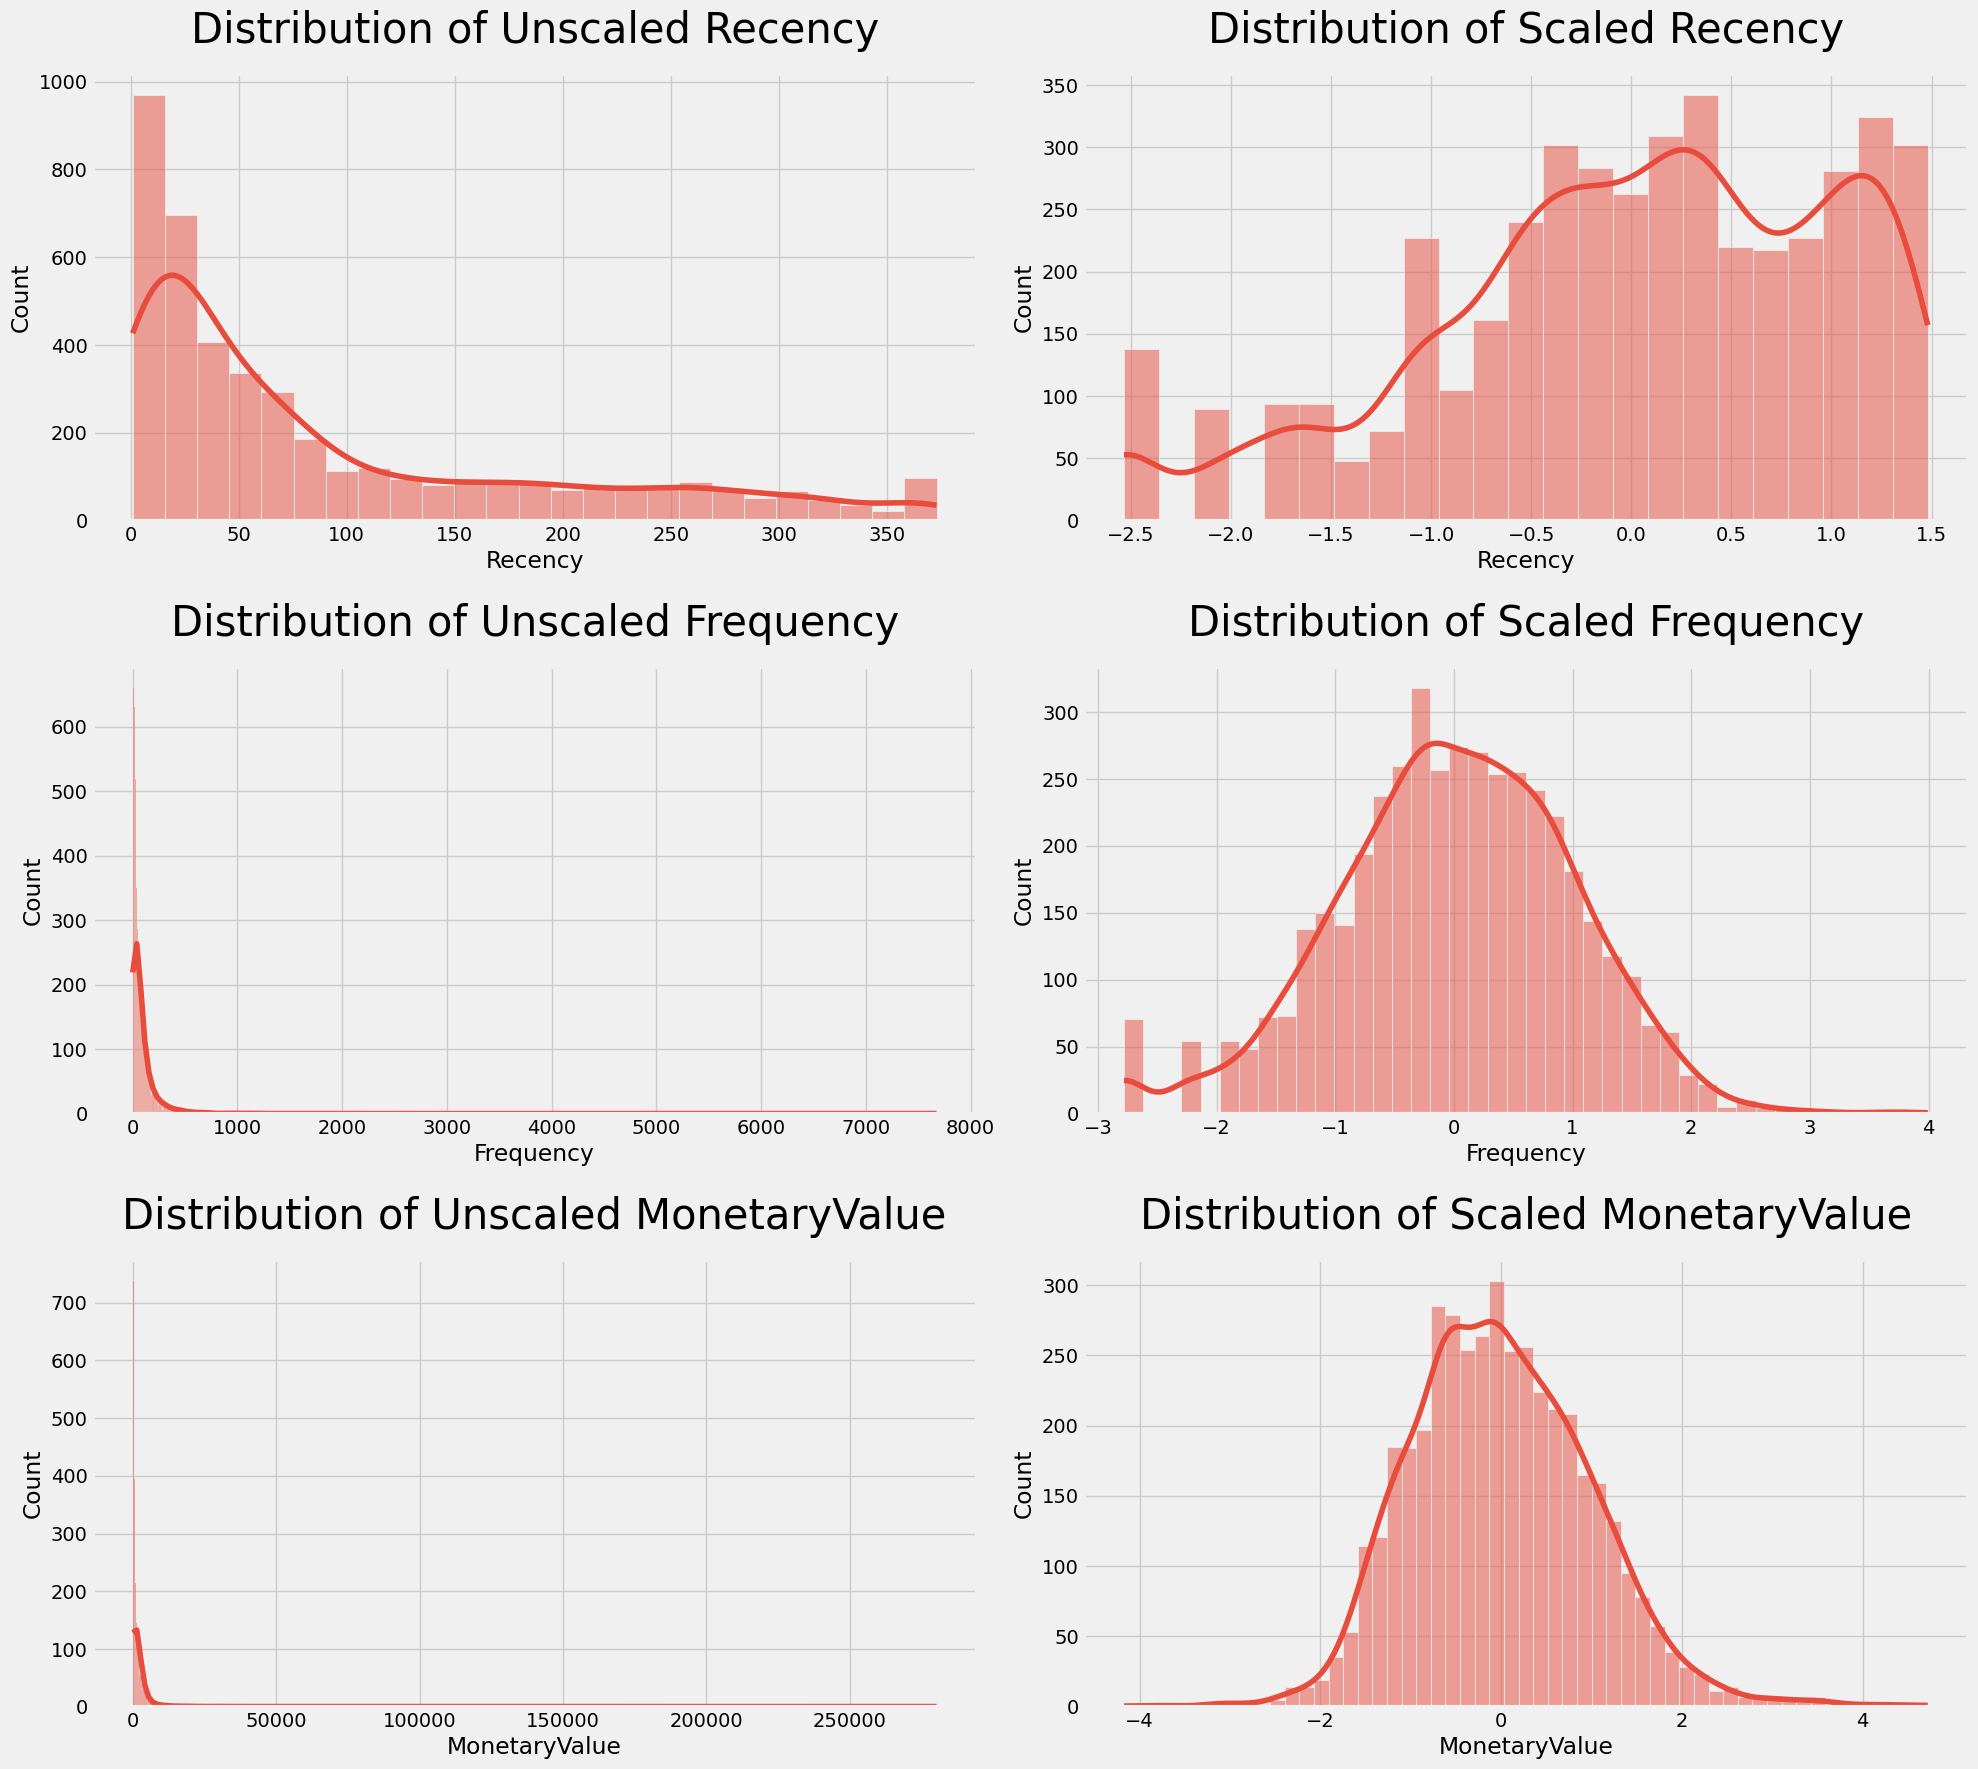

In [34]:
cont_features = ['Recency', 'Frequency', 'MonetaryValue']


fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20, 18))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cont_features):
    sns.histplot(rfm[feature], kde=True, color='#e74c3c', ax=ax[i][0])
    sns.histplot(rfm_scaled[feature], kde=True, color='#e74c3c', ax=ax[i][1])

    ax[i][0].set_title(f'Distribution of Unscaled {feature}', size=30, y=1.05)
    ax[i][1].set_title(f'Distribution of Scaled {feature}', size=30, y=1.05)

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

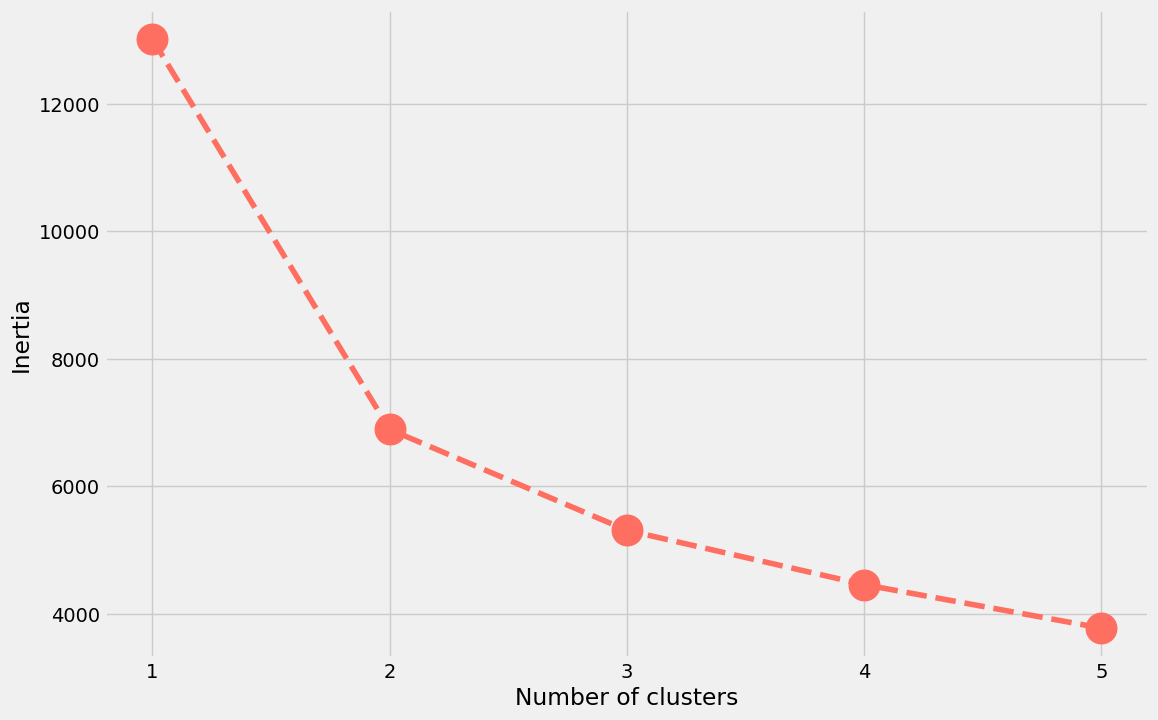

In [35]:
plt.figure(figsize=(10,8))

kls = np.arange(1,6,1)
inertias=[]
for k in kls :
    knc = KMeans(n_clusters=k, random_state=42)
    knc.fit(rfm_scaled)
    inertias.append(knc.inertia_)


fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(kls, inertias,'--o', markersize=22, color='#ff6f61')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(kls)
plt.show()

# K-Means clustering

In [36]:
kmc = KMeans(n_clusters=3, random_state=42)
kmc.fit(rfm_normalized)
rfm['RFM Cluster'] = kmc.labels_

rfm_s=rfm.groupby('RFM Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count']})


rfm_s.rename(columns = {'mean' : 'Mean','count' : 'Count'},
               inplace = True)



display(rfm_s.style.background_gradient(cmap='summer_r'))

In [37]:
rfm['RFM Cluster']=rfm['RFM Cluster'].map({0: 'K_Bronze', 1: 'K_Gold',2:'K_Silver'})
rfm.sample(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,Robust RFM Level,RFM Cluster
CustomerID,,,,,,,,,,
14988.0,211,40,334.54,1,2,1,1.02.01.0,4,Bronze,K_Silver
18248.0,122,47,804.02,1,2,2,1.02.02.0,5,Bronze,K_Bronze
16080.0,81,10,217.16,2,1,1,2.01.01.0,4,Bronze,K_Silver
13098.0,1,572,28882.44,3,3,3,3.03.03.0,9,Gold,K_Gold
12358.0,1,19,1168.06,3,1,2,3.01.02.0,6,Silver,K_Gold
16057.0,16,121,2263.12,3,3,3,3.03.03.0,9,Gold,K_Gold
15940.0,311,1,35.80,1,1,1,1.01.01.0,3,Bronze,K_Silver
16967.0,189,21,319.02,1,1,1,1.01.01.0,3,Bronze,K_Silver
14584.0,169,98,1033.06,1,3,2,1.03.02.0,6,Silver,K_Bronze


In [38]:
rfm_scaled['RFM Cluster'] = kmc.labels_
rfm_scaled['Robust RFM Level'] = rfm['Robust RFM Level']
rfm_scaled.reset_index(inplace = True)
rfm_scaled['RFM Cluster']=rfm_scaled['RFM Cluster'].map({0: 'K_Bronze', 1: 'K_Gold',2:'K_Silver'})


rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'Robust RFM Level',
                                                  'RFM Cluster'], var_name = 'Metrics', value_name = 'Value')

rfm_melted.head()

,CustomerID,Robust RFM Level,RFM Cluster,Metrics,Value
0,12346.0,Bronze,K_Bronze,Recency,1.388122
1,12347.0,Gold,K_Gold,Recency,-2.064513
2,12348.0,Silver,K_Bronze,Recency,0.393612
3,12349.0,Gold,K_Bronze,Recency,-0.574296
4,12350.0,Bronze,K_Silver,Recency,1.356073


# Snakeplot and HeatMap

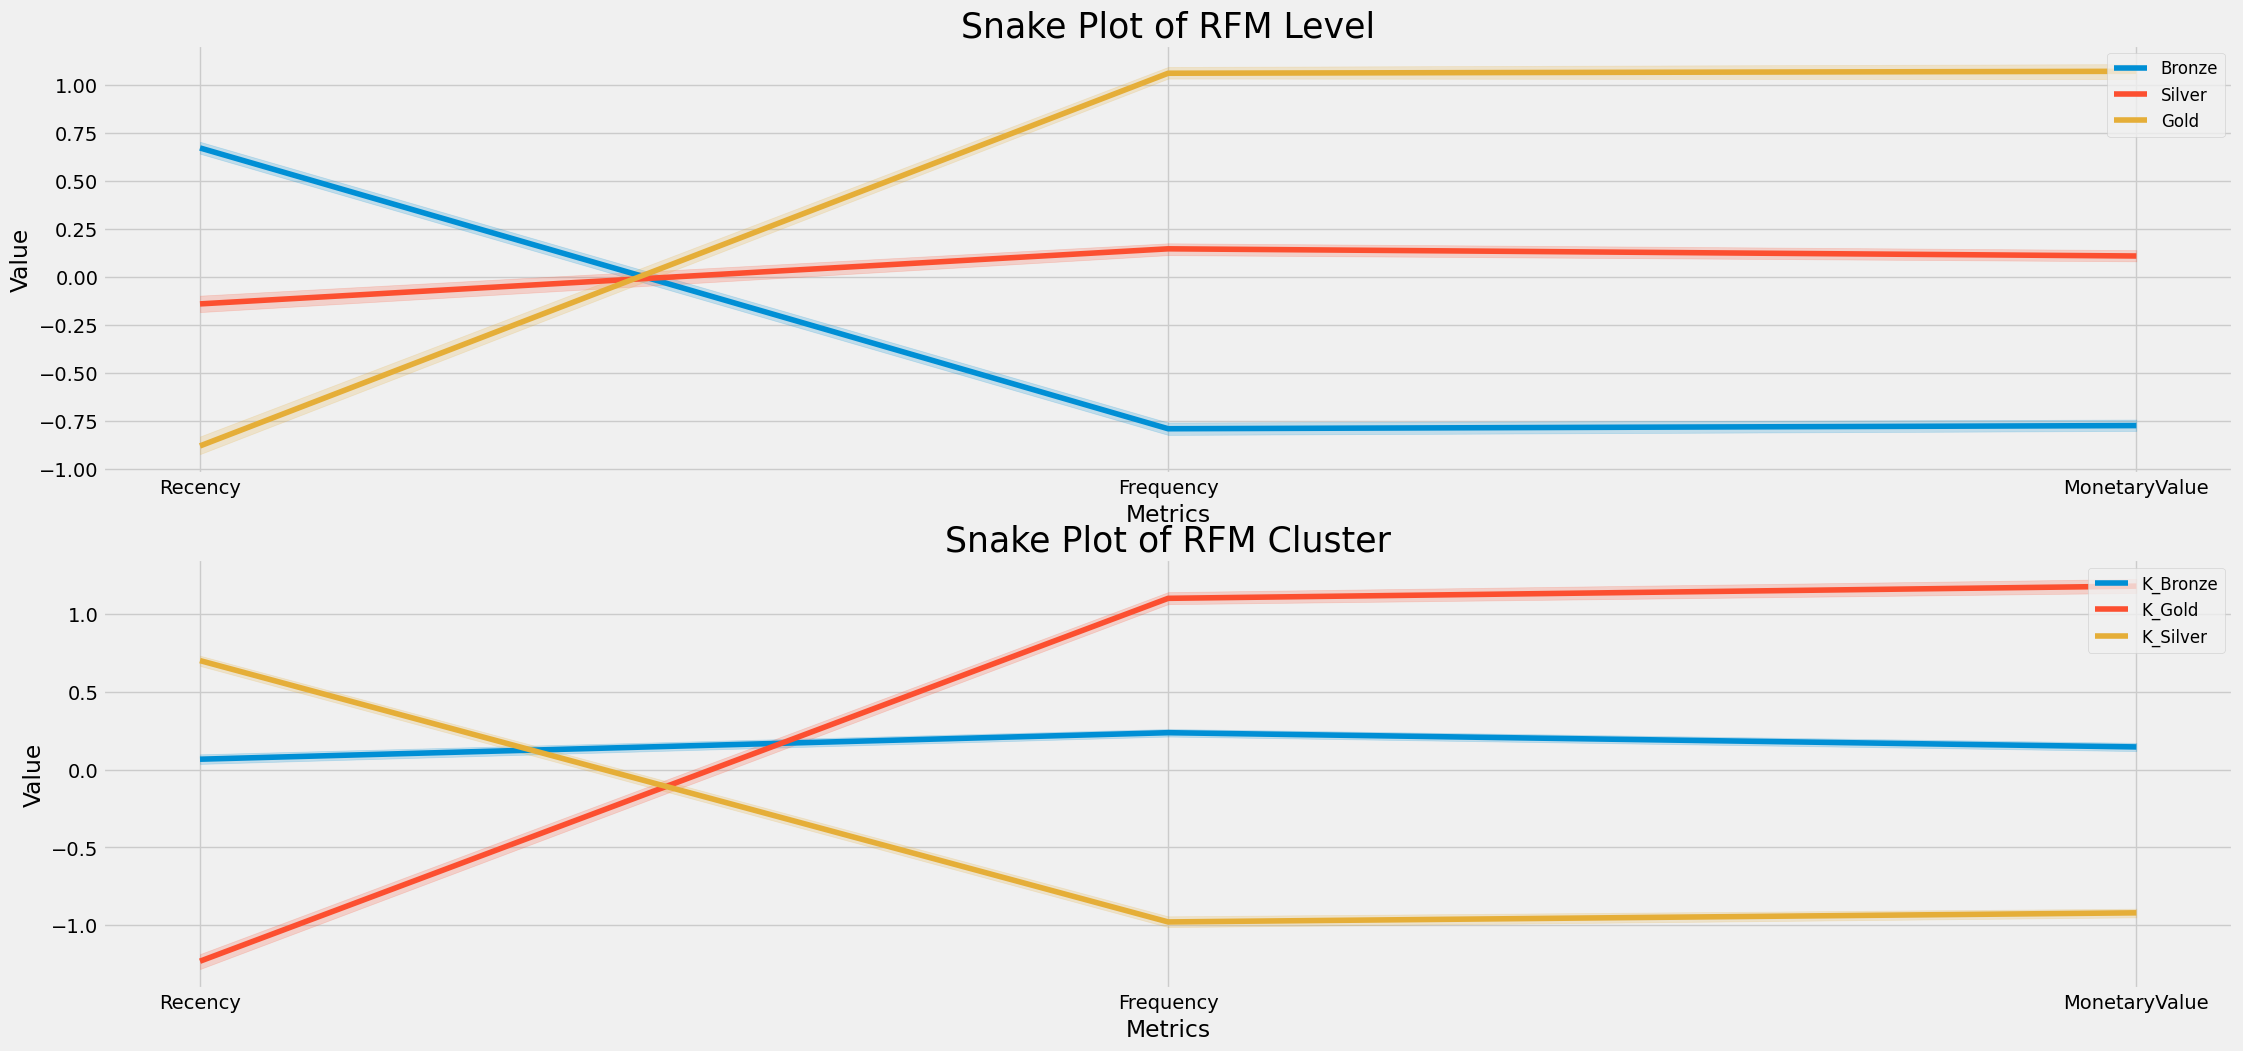

In [39]:
ig, ax = plt.subplots(nrows=2, figsize=(15,8))
plt.subplots_adjust(right=1.5, top=1.25)


sns.lineplot(x = 'Metrics', y = 'Value', hue = 'Robust RFM Level', data = rfm_melted, ax=ax[0])
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM Cluster', data = rfm_melted, ax=ax[1])

ax[0].set_title('Snake Plot of RFM Level', size=25)
ax[1].set_title('Snake Plot of RFM Cluster', size=25)
ax[0].legend(loc='upper right', prop={'size': 12})
ax[1].legend(loc='upper right', prop={'size': 12})

plt.show()

In [40]:
# Calculate the total average of RFM features
total_avg = rfm[['Recency', 'Frequency', 'MonetaryValue']].mean()

# Calculate the mean of RFM features for each 'Robust RFM Level'
cluster_avg = rfm.groupby('Robust RFM Level')[['Recency', 'Frequency', 'MonetaryValue']].mean()

# Calculate the proportion of RFM features relative to the total average for each 'Robust RFM Level'
prop_rfm = cluster_avg / total_avg - 1

# Calculate the mean of RFM features for each 'RFM Cluster'
cluster_avg_K = rfm.groupby('RFM Cluster')[['Recency', 'Frequency', 'MonetaryValue']].mean()

# Calculate the proportion of RFM features relative to the total average for each 'RFM Cluster'
prop_rfm_K = cluster_avg_K / total_avg - 1


<ipython-input-40-900e4d0f8274>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_avg = rfm.groupby('Robust RFM Level')[['Recency', 'Frequency', 'MonetaryValue']].mean()


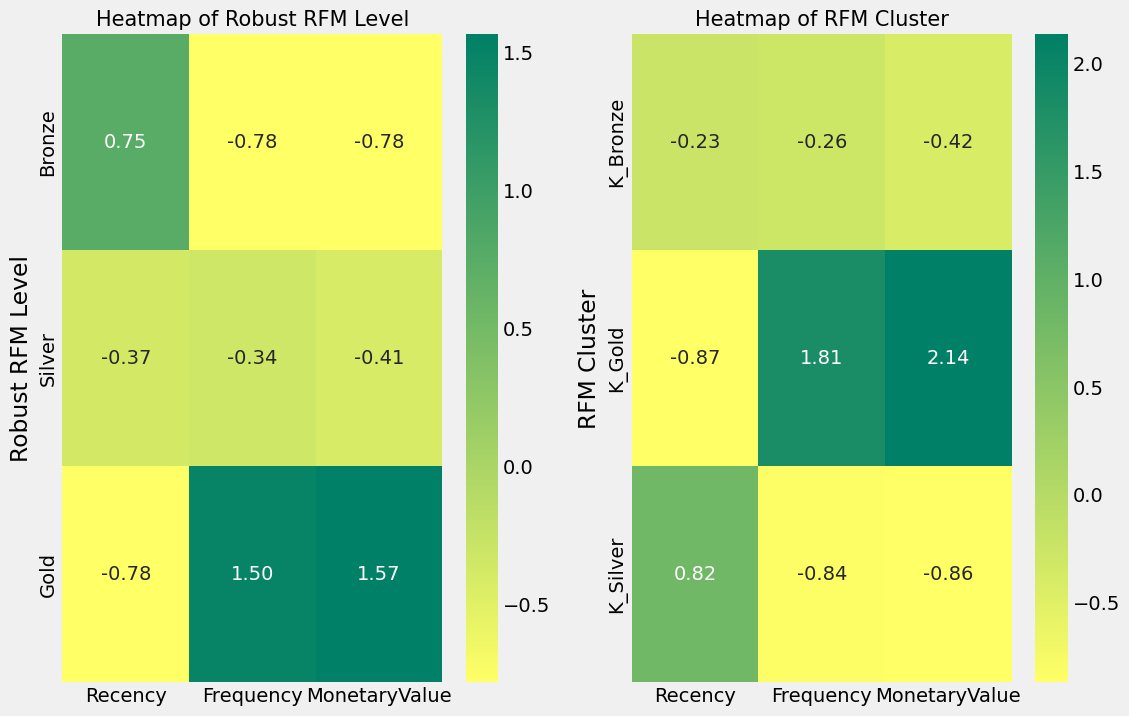

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
sns.heatmap(prop_rfm, cmap= 'summer_r', fmt= '.2f', annot = True, ax=ax[0])
sns.heatmap(prop_rfm_K, cmap= 'summer_r', fmt= '.2f', annot = True, ax=ax[1])

ax[0].set_title('Heatmap of Robust RFM Level', size=15)
ax[1].set_title('Heatmap of RFM Cluster', size=15)

plt.show()